<a href="https://colab.research.google.com/github/alexlapshov89/ALapshov_coding/blob/main/EDA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проектирование модели прогнозирования рейтинга отеля

Проект проведен в рамках соревнования на [Kaggle.com](https://www.kaggle.com/competitions/sf-booking). Целью проекта является решение задачи регрессии - создание модели машинного обучения, прогнозирующей рейтинг отеля по отзыву.

В требованиях к выполнению проекта сделан акцент на разведывательном анализе данных. Т.о. тип модели, ее параметры, а также метрика качества используются аналогичные baseline'у и не подлежат корректировке.

In [ ]:
#!pip install category_encoders

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # work with regular expressions
#import category_encoders as ce
import folium # библиотека для отображения интрактивной геолокации
from sklearn import preprocessing
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from scipy.stats import normaltest

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Загрузка данных

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/Skillfactory/EDA-Project/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/Colab Notebooks/Skillfactory/EDA-Project/data/hotels_test.csv.zip
/content/drive/MyDrive/Colab Notebooks/Skillfactory/EDA-Project/data/hotels_train.csv.zip
/content/drive/MyDrive/Colab Notebooks/Skillfactory/EDA-Project/data/submission.csv.zip


In [ ]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

In [ ]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Skillfactory/EDA-Project/data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv.zip') # самбмишн

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


Описание признаков:
1. hotel_address — адрес отеля
2. review_date — дата, когда рецензент разместил соответствующий отзыв
3. average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год
4. hotel_name — название отеля
5. reviewer_nationality — страна рецензента
6. negative_review — отрицательный отзыв, который рецензент дал отелю
7. review_total_negative_word_counts — общее количество слов в отрицательном отзыв
8. positive_review — положительный отзыв, который рецензент дал отелю
9. review_total_positive_word_counts — общее количество слов в положительном отзыве
10. reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта
11. total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом
12. total_number_of_reviews — общее количество действительных отзывов об отеле
13. tags — теги, которые рецензент дал отелю
14. days_since_review — количество дней между датой проверки и датой очистки
15. additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
16. lat — географическая широта отеля
17. lng — географическая долгота отеля

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропуски данных имеются только в признаках координат размещения отеля.

### **Разведывательный анализ данных**

Далее приводится исследование признаков датасета, проектирование новых признаков, очистка данных.

##### **Признак 'hotel_address'**

In [ ]:
# Вывод нескольких адресов отелей для определения вариантов обработки
print('Примеры адресов отелей:\n')
for i in np.random.randint(data.shape[0],size=(5)):
  print(data['hotel_address'].iloc[i])

Примеры адресов отелей:

92 Rue Du Cherche Midi 6th arr 75006 Paris France
75 Gower Street Camden London WC1E 6HJ United Kingdom
15 Montague St Bloomsbury Camden London WC1B 5BJ United Kingdom
173 Gloucester Place Westminster Borough London NW1 6DX United Kingdom
97 Great Russell Street Bloomsbury Camden London WC1B 3LB United Kingdom


В записи адреса содержится информация о стране и городе размещения отеля

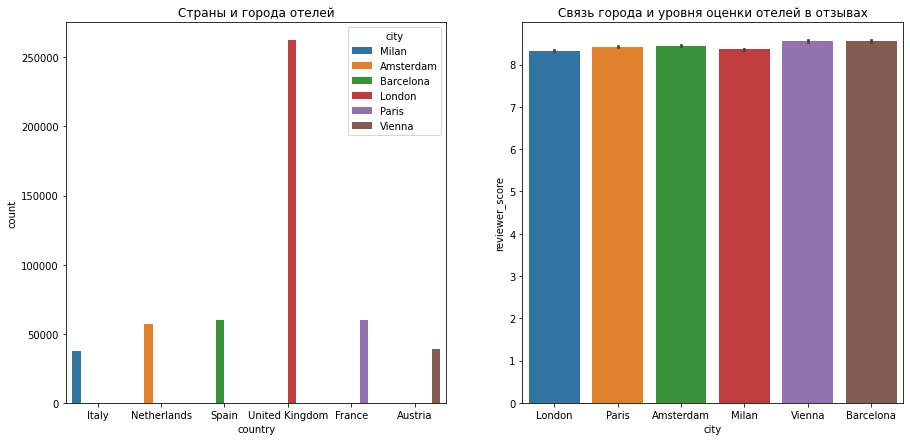

In [ ]:
# Функция определяет страну отеля
def get_country(address):
    country = address.split()[-1]
    if country=='Kingdom':
        country = 'United Kingdom'
    return country
#  Функция определяет город расположения отеля
def get_city(address):
    city = address.split()[-2]
    if city=='United':
        city = address.split()[-5]
    return city

data['country'] = data['hotel_address'].apply(get_country)
data['city'] = data['hotel_address'].apply(get_city)
# визуализация
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,7))
cp = sns.countplot(data=data,x='country',hue='city',ax=ax[0])
cp.set_title('Страны и города отелей')
bp = sns.barplot(data=data[data['sample']==1],
                 x='city',
                 y='reviewer_score',
                 ax=ax[1])
bp.set_title('Связь города и уровня оценки отелей в отзывах');

В датасете размещены отзывы на отели из 6 стран, при этом в каждой стране есть данные только по одному городу. Признаки города и страны полностью коррелированы, один из них должен быть удален. Также удаляется признак 'hotel_address'.

In [ ]:
data = data.drop(['country','hotel_address'],axis=1)

#### **Признаки 'lat', 'lng'**

Сперва визуализируются координаты размещения отелей.

In [ ]:
# таблица уникальных наименований отелей и их координат
hotels = data.groupby(by=['city','hotel_name'],as_index=False)[['lat','lng']].median()
print('Количество отелей в датасете:', hotels.shape[0])
print('Количество пропусков в данных:', hotels.isnull().sum().sum())
hotels.head(10)

Количество отелей в датасете: 1494
Количество пропусков в данных: 34


,city,hotel_name,lat,lng
0,Amsterdam,Albus Hotel Amsterdam City Centre,52.365823,4.893243
1,Amsterdam,Amadi Panorama Hotel,52.358881,4.988604
2,Amsterdam,Amadi Park Hotel,52.364962,4.873495
3,Amsterdam,Ambassade Hotel,52.369391,4.887172
4,Amsterdam,Amsterdam Canal Residence,52.359478,4.895853
5,Amsterdam,Amsterdam Marriott Hotel,52.362514,4.880008
6,Amsterdam,Andaz Amsterdam Prinsengracht A Hyatt Hotel,52.367837,4.883079
7,Amsterdam,Apollo Hotel Amsterdam,52.348610,4.884429
8,Amsterdam,Apollofirst Boutique Hotel,52.350396,4.875640
9,Amsterdam,Banks Mansion All Inclusive Hotel,52.365387,4.893198


На географическую карту наносятся точки размещения отелей, а также координаты городских центров.

In [ ]:
# для отображения в foleum пропущенные значения удаляются
hotels_folium = hotels.dropna()
# интрактивная визуализация размещения отелей на карте мира
map = folium.Map(location=[hotels_folium['lat'].mean(),hotels_folium['lng'].mean()], zoom_start=5)
for i in hotels_folium.index:
  tooltip = hotels_folium['hotel_name'].loc[i]
  folium.Marker([hotels_folium['lat'].loc[i],hotels_folium['lng'].loc[i]], popup=tooltip, tooltip=tooltip).add_to(map)
# координаты городских центров (получены из внешних источников)
cities_centers = pd.DataFrame([['Milan',45.4643, 9.18951],
                       ['Amsterdam',52.374, 4.88969],
                       ['Barcelona',41.3888, 2.15899],
                       ['London',51.5085, -0.12574],
                       ['Paris',48.8534, 2.3488],
                       ['Vienna',48.2085, 16.3721]],columns=['city','lat','lng'])
for i in cities_centers.index:
  folium.Marker([cities_centers['lat'].loc[i],cities_centers['lng'].loc[i]], icon=folium.Icon(color="red", icon="info-sign")).add_to(map)
map

По полученным наблюдениям видно, что отели находятся в разных районах городов. Далее вводится признак отдаленности от центра города. Для отелей, координаты которых неизвестны, пропуски признака отдаленности от городского центра будут заполнены средним значением (в зависимости от города).

In [ ]:
# включаем в таблицу с отелями столбцы координат городских центров
hotels = hotels.merge(cities_centers,on='city',suffixes=('_hotel','_center'))
# вычисляем евклидово расстояние между центром и отелем
hotels['distance'] = np.sqrt((hotels['lat_hotel']-hotels['lat_center'])**2 + (hotels['lng_hotel']-hotels['lng_center'])**2)
# удаляем координаты из датасета
hotels = hotels.drop(['lat_hotel','lat_center','lng_hotel','lng_center'],axis=1)
dist_means = hotels.groupby(by='city',as_index=False).mean()
# для каждого города заменяем пропуск в признаке 'distance' на среднее значение расстояния для этого города
for city in hotels['city'].unique():
  dist_mean = dist_means[dist_means['city']==city]['distance'].values[0]
  mask = hotels['city']==city
  hotels[mask] = hotels[mask].fillna({'distance':dist_mean})
# добавляем данные о расстоянии до центра в основной датасет data
data = data.merge(hotels,how='left',on=['city','hotel_name'])

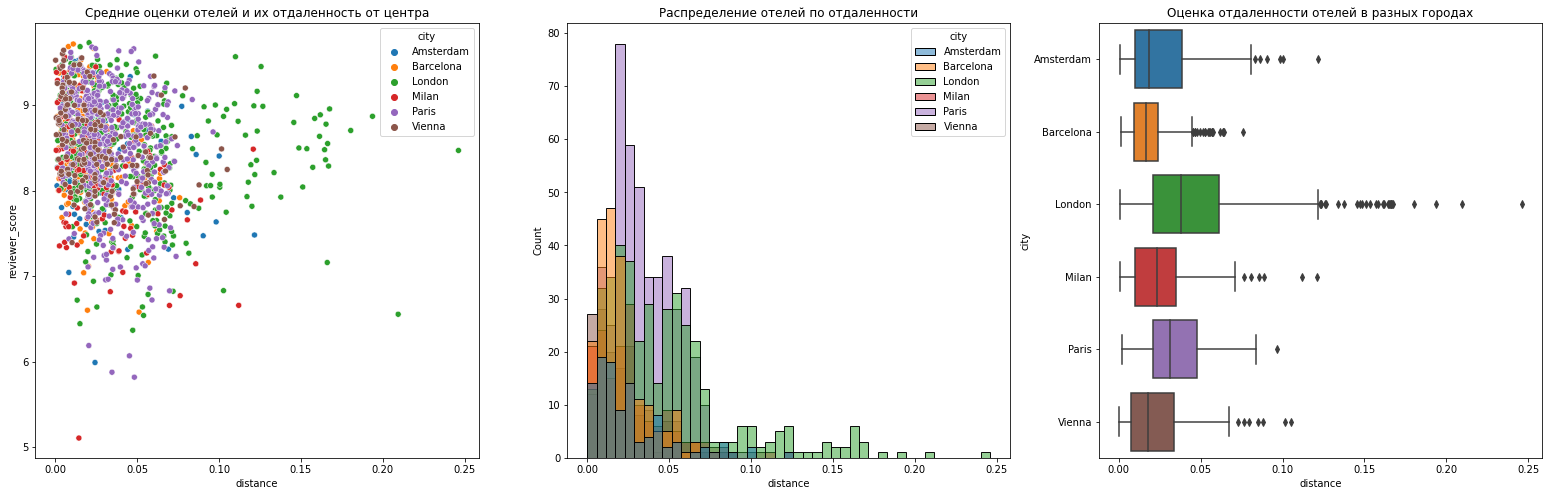

In [ ]:
# визуализация
# группируем данные по отелям и получаем средние расстояния и оценки
hotels_score_per_distance = data[data['sample']==1].groupby(by=['city','hotel_name'],as_index=False)[['distance','reviewer_score']].mean()
# строим распределение средних оценок и расстояний, также помечаем город
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(27,8))
sp = sns.scatterplot(data=hotels_score_per_distance,
                     x='distance',
                     y='reviewer_score',
                     hue='city',
                     ax=ax[0])
sp.set_title('Средние оценки отелей и их отдаленность от центра')
hp = sns.histplot(data=hotels_score_per_distance,x='distance',hue='city',ax=ax[1])
hp.set_title('Распределение отелей по отдаленности')
bp = sns.boxplot(data=hotels_score_per_distance,x='distance',y='city',ax=ax[2])
bp.set_title('Оценка отдаленности отелей в разных городах');

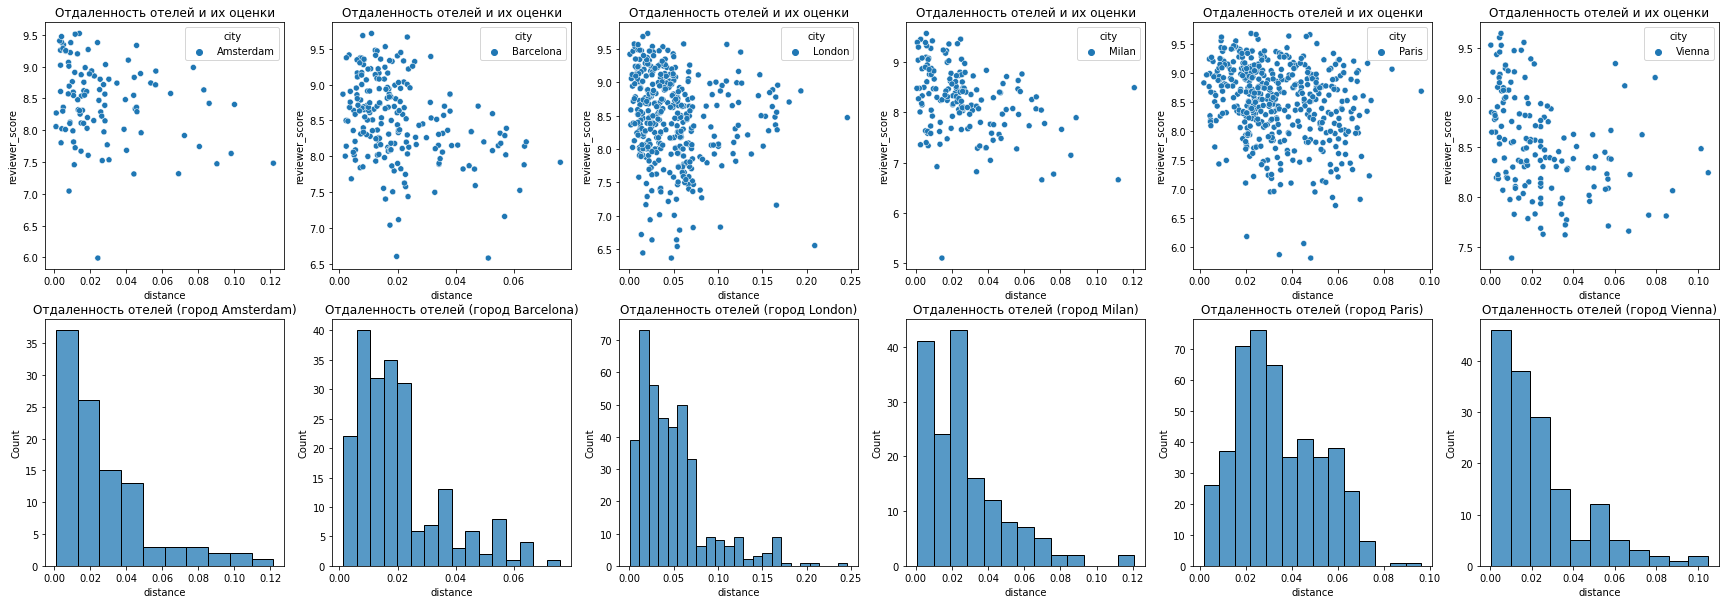

In [ ]:
cities = hotels_score_per_distance['city'].unique()
fig,ax = plt.subplots(ncols=len(cities),nrows=2,figsize=(30,10))
i=0
for city in cities:
  sp = sns.scatterplot(data=hotels_score_per_distance[hotels_score_per_distance['city']==city],
                       x='distance',
                       y='reviewer_score',
                       hue='city',
                       ax=ax[0,i])
  sp.set_title(f'Отдаленность отелей и их оценки')
  hp = sns.histplot(data=hotels_score_per_distance[hotels_score_per_distance['city']==city],
                       x='distance',
                       ax=ax[1,i])
  hp.set_title(f'Отдаленность отелей (город {city})')
  i+=1

Построенные визуализации показывают, что в некоторых городах с уменьшением расстояния до городского центра кучность точек переносится выше, что указывает на некоторое увеличение среднего значения рейтинга. При этом разброс значения рейтинга все равно велик.

In [ ]:
# удаляем признаки широты и долготы
data = data.drop(['lat','lng'],axis=1)

#### **Признак 'tags' - теги**

In [ ]:
# Обработка признака 'tags'. Извлечение тэгов в список из строки
def tags_str_to_list(tags):
    list = re.split(r' \', \' ',tags)
    list[0] = list[0].replace('[\' ','')
    list[-1] = list[-1].replace(' \']','')
    return list

data['tags'] = data['tags'].apply(tags_str_to_list)

# Вывод нескольких записей тегов
print('Примеры тегов в отзывах (случайная выборка из 10 отзывов)')
for i in np.random.randint(data.shape[0],size=(10)):
  print(data['tags'].iloc[i])

Примеры тегов в отзывах (случайная выборка из 10 отзывов)
['Leisure trip', 'Couple', 'Special Offer Queen Room', 'Stayed 2 nights', 'Submitted from a mobile device']
['Business trip', 'Solo traveler', 'Superior Double Room with Internal View', 'Stayed 2 nights']
['Solo traveler', 'Twin Room', 'Stayed 3 nights']
['Leisure trip', 'Group', 'Double or Twin Room', 'Stayed 1 night']
['Leisure trip', 'Couple', 'Double Room Non Smoking', 'Stayed 3 nights', 'Submitted from a mobile device']
['Leisure trip', 'Couple', 'Classic Double Room', 'Stayed 2 nights', 'Submitted from a mobile device']
['Leisure trip', 'Solo traveler', 'Standard Double Room', 'Stayed 3 nights']
['Leisure trip', 'Couple', 'Deluxe Double Room', 'Stayed 1 night', 'Submitted from a mobile device']
['Leisure trip', 'Family with young children', 'Two Adjacent Rooms 6 persons', 'Stayed 2 nights']
['Leisure trip', 'Couple', 'Deluxe Double Room', 'Stayed 1 night']


Нужно узнать все возможные теги для дальнейшего преобразований данных.

In [ ]:
all_tags = []
for i in range(data.shape[0]):
  list_of_tags = data['tags'].iloc[i]
  for tag in list_of_tags:
    if tag not in all_tags:
      all_tags.append(tag)
print('Количество всех возможных тегов',len(all_tags))
print('Первые 50 тегов из облака тегов')
all_tags[:50]

Количество всех возможных тегов 2428
Первые 50 тегов из облака тегов


['Leisure trip',
 'Couple',
 'Double Room',
 'Stayed 2 nights',
 'Group',
 'Triple Room',
 'Stayed 1 night',
 'Business trip',
 'Solo traveler',
 'Twin Room',
 'Submitted from a mobile device',
 'Ambassador Junior Suite',
 'Classic Double or Twin Room',
 'Standard Double or Twin Room',
 'Queen Room',
 'Executive Room',
 'Stayed 3 nights',
 'Double or Twin Room',
 'Standard Triple Room',
 'Superior Double Room',
 'Large Room',
 'Stayed 4 nights',
 'Superior King Room',
 'Junior Suite',
 'Royal Suite with Canal View',
 'Stayed 7 nights',
 'Standard Single Room',
 'King Room',
 'Standard Double Room',
 'Deluxe Double or Twin Room',
 'Stayed 5 nights',
 'Family with young children',
 'Suite',
 'Basic Double Room',
 'Club Double Room',
 'Classic Room',
 'Family with older children',
 'Standard Twin Room',
 'Luxury Double Room',
 'King Executive Plus Room',
 'Stayed 6 nights',
 'Superior Double or Twin Room',
 'Club Single Room',
 'Deluxe Queen Room',
 'Deluxe Room',
 'Superior Queen Room',


Полученное количество уникальных тегов достаточно велико, что затрудняет анализ. Преимущественно теги касаются описания номера, такие теги не систематизированы, что порождает большое количество уникальных значений. Однако в полученных примерах заметно, что набор тегов включает в себя несколько тегов, из которых можно получить дополнительные признаки: тип поездки - деловая или личная, количество ночей, состав отдыхающих.

##### Цель поездки - личная/деловая

Количество отзывов без тега цели поездки (unknown): 15021 (2.91 %)


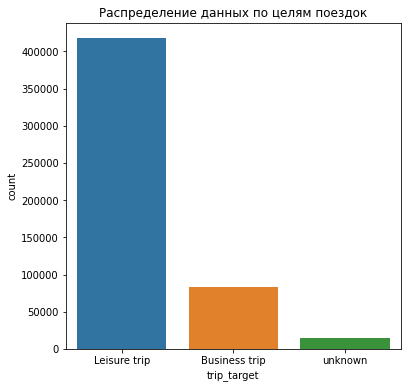

In [ ]:
# Создание признака 'trip_target' - цель поездки: личная/деловая/неизвестно
def get_trip_target(tags):
    if 'Leisure trip' in tags:
        return 'Leisure trip'
    elif 'Business trip' in tags:
        return 'Business trip'
    else:
        return 'unknown'
    
data['trip_target'] = data['tags'].apply(get_trip_target)
print('Количество отзывов без тега цели поездки (unknown): {} ({:.2f} %)'.format(data[data['trip_target']=='unknown'].shape[0],
                                                                                 data[data['trip_target']=='unknown'].shape[0]/data.shape[0]*100))
# визуализация
plt.figure(figsize=(6,6))
countplot = sns.countplot(data=data,x='trip_target')
countplot.set_title('Распределение данных по целям поездок');

Поиск тега выявил, что около 3 % данных не имеют тега цели поездки. Остальные записи распределены с явным перевесом в пользу поездок делового характера.

##### Количество ночей

Нет данных о длительности пребывания: 192 записей (0.04 %)
Пропуски заполнены средним значением - 2 ночи(ночей)


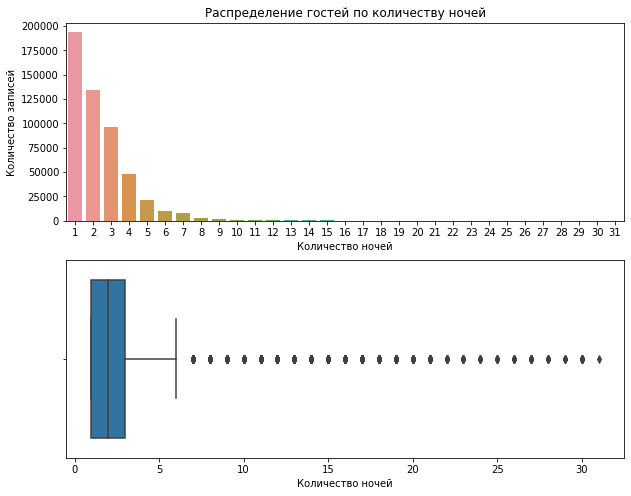

In [ ]:
# Создание признака 'count_nights' - количество ночей
def get_count_nights(tags):
    for tag in tags:
        result = re.findall(r'Stayed \d+',tag)
        if result!=[]:
            count_nights = int(result[0].split()[-1])
            return count_nights
    
data['count_nights'] = data['tags'].apply(get_count_nights)
print('Нет данных о длительности пребывания: {} записей ({:.2f} %)'.format(data['count_nights'].isnull().sum(),
                                                                       data['count_nights'].isnull().sum()/data.shape[0]*100))
# заполнение пропусков средним значением:
count_night_mean = int(data['count_nights'].mean())
data['count_nights'] = data['count_nights'].fillna(count_night_mean).astype(int)
print('Пропуски заполнены средним значением - {} ночи(ночей)'.format(count_night_mean))
# преобразование данных к типу 'int'
#data['count_nights'] = data['count_nights'].astype(int)
# визуализация
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(10,8))
countplot = sns.countplot(data=data,x='count_nights',ax=ax[0])
countplot.set_title('Распределение гостей по количеству ночей')
countplot.set_xlabel('Количество ночей')
countplot.set_ylabel('Количество записей')
boxplot = sns.boxplot(data=data,x='count_nights',ax=ax[1])
boxplot.set_xlabel('Количество ночей');

Графики демонстрируют, что в 75% случаев число ночей не более 3, а статистически значимая выборка ограничена числом 6. Целесообразно убрать записи с большим числом ночей, т.к. данные значения аномальны и выбиваются из общей статистики. Проведем анализ количества записей с большим количеством ночей.

In [ ]:
for night_counts in range(5,10):
  mask = data['count_nights']>night_counts
  print('Количество записей, где количество ночей более {}: {} ({:.2f} %)'.format(night_counts,
                                                                                  data[mask].shape[0],
                                                                                  data[mask].shape[0]/data.shape[0]*100),end=' ')
  mask = (data['sample']==1)&(mask)
  print('из них в обучающей выборке {} ({:.2f} %)'.format(data[mask].shape[0], data[mask].shape[0]/data.shape[0]*100))

Количество записей, где количество ночей более 5: 23481 (4.55 %) из них в обучающей выборке 17662 (3.42 %)
Количество записей, где количество ночей более 6: 13705 (2.66 %) из них в обучающей выборке 10263 (1.99 %)
Количество записей, где количество ночей более 7: 6306 (1.22 %) из них в обучающей выборке 4714 (0.91 %)
Количество записей, где количество ночей более 8: 3804 (0.74 %) из них в обучающей выборке 2804 (0.54 %)
Количество записей, где количество ночей более 9: 2511 (0.49 %) из них в обучающей выборке 1838 (0.36 %)


In [ ]:
# убираем данные с числом ночей более 7 из обучающей выборки
data = data.drop(index=data[(data['sample']==1)&(data['count_nights']>7)].index,axis=0)
data.shape

(511024, 19)

Поиск тега дал хороший результат, только 0.04 % данных не имеют такой информации (пропуски заполнены средним значением). В распределении отзывов по количеству ночей наблюдается экспоненциальная зависимость, удалены записи с числом ночей более 7 (около 1 % от объема обучающей выборки).

##### Тип гостей

Количество записей без метки 'тип гостя': 0 (0.00 %)


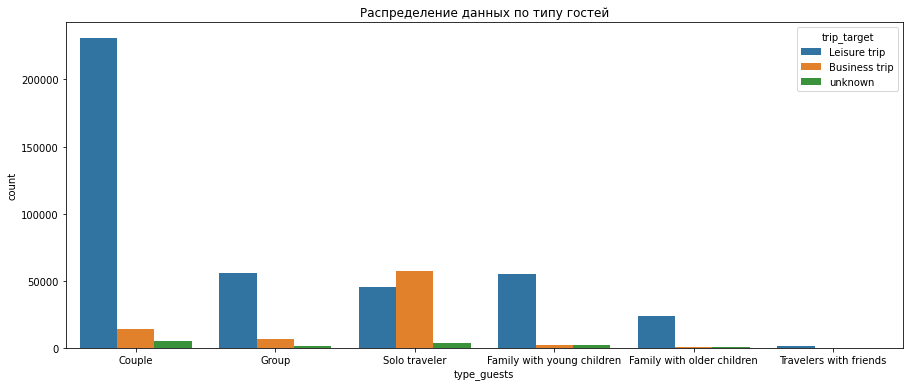

In [ ]:
# Создание признака 'type_guests' - тип гостей
def get_type_guests(tags):
    if 'Solo traveler' in tags:
        return 'Solo traveler'
    elif 'Couple' in tags:
        return 'Couple'
    elif 'Group' in tags:
        return 'Group'
    elif 'Family with young children' in tags:
        return 'Family with young children'
    elif 'Family with older children' in tags:
        return 'Family with older children'
    elif 'Travelers with friends' in tags:
        return 'Travelers with friends'
    else:
        return 'unknown'
    
data['type_guests'] = data['tags'].apply(get_type_guests)
print('Количество записей без метки \'тип гостя\': {} ({:.2f} %)'.format(data[data['type_guests']=='unknown'].shape[0],
                                                                         data[data['type_guests']=='unknown'].shape[0]/data.shape[0]*100))
# визуализация
plt.figure(figsize=(15,6))
countplot = sns.countplot(data=data,x='type_guests',hue='trip_target')
countplot.set_title('Распределение данных по типу гостей');

Поиск тегов "тип гостя" дал отличные результаты: все данные без остатка разбиты на 6 категорий. Дополнительно отмечается, что во всех указанных группах, кроме группы "Solo traveler" явный перевес в пользу поездок в личных целях. Целесообразно устранить метки "unknown", заменив их на "Bisiness trip", если в "type_guests" записано "Solo traveler", иначе - "Leisure trip"

In [ ]:
# замена метки 'unknown' ('trip_target')

trip_target = data['trip_target'].copy()
replace_unknown_target = data[data['trip_target']=='unknown']['type_guests'].apply(lambda x: 'Business trip' if x=='Solo traveler' else 'Leisure trip')
mask = trip_target[trip_target=='unknown'].index
trip_target.loc[mask] = replace_unknown_target.values
data['trip_target'] = trip_target.values
data['trip_target'].value_counts()

Leisure trip     424626
Business trip     86398
Name: trip_target, dtype: int64

Также целесообразно объединить категории 'Travelers with friends' и 'Group'.

In [ ]:
data['type_guests'] = data['type_guests'].apply(lambda x: 'Group' if x=='Travelers with friends' else x)
data['type_guests'].value_counts()

Couple                        250680
Solo traveler                 107397
Group                          67052
Family with young children     59989
Family with older children     25906
Name: type_guests, dtype: int64

##### Заказ через мобильное устройство

In [ ]:
# Бинарный признак 'Submitted from a mobile device' из набора тегов
data['Submitted from a mobile device'] = data['tags'].apply(lambda x:1 if 'Submitted from a mobile device' in x else 0)
print('Отправлено с мобильного устройства',round(data['Submitted from a mobile device'].mean()*100,3),' % отзывов')

Отправлено с мобильного устройства 59.629  % отзывов


#### **Признаки 'review_date','days_since_review'**

In [ ]:
# преобразование 'review_date' к типу datetime
data['review_date'] = pd.to_datetime(data['review_date'])
print('Данные представлены за период с {} по {}'.format(data['review_date'].min(),data['review_date'].max()))
print('Примеры данных - даты отзыва и количества дней после отзыва')
for i in np.random.randint(data.shape[0],size=(3)):
  print(data[['review_date','days_since_review']].iloc[i])

Данные представлены за период с 2015-08-04 00:00:00 по 2017-08-03 00:00:00
Примеры данных - даты отзыва и количества дней после отзыва
review_date          2016-08-12 00:00:00
days_since_review                356 day
Name: 191937, dtype: object
review_date          2015-12-01 00:00:00
days_since_review                611 day
Name: 248979, dtype: object
review_date          2016-06-14 00:00:00
days_since_review                415 day
Name: 312407, dtype: object


Судя по нескольким примерам выше признаки даты отзыва и количество дней после отзыва связаны. Выдвигается следующая гипотеза: число дней после отзыва при сложении с датой отзыва даст дату выгрузки данных (только одну дату).

In [ ]:
# Функция определения числа дней в строке
def get_count_days(text):
    days_count = int(re.findall(r'\d+',text)[0])
    return days_count
# преобразование данных в столбце 'days_since_review' к типу Timedelta
data['days_since_review'] = data['days_since_review'].apply(get_count_days)
data['days_since_review'] = data['days_since_review'].apply(lambda x:pd.Timedelta(days=x))

# признак-даты 'scrape_date'
data['scrape_date'] = data['review_date']+data['days_since_review']
data['scrape_date'].unique()


array(['2017-08-03T00:00:00.000000000'], dtype='datetime64[ns]')

Получен результат, что все данные были выгружены(очищены) в одно время, 3 августа 2017 года, гипотеза подтвердилась. Это говорит о том, что признаки 'days_since_review' и 'scrape_date' линейно связаны с 'review_date', поэтому целесообразно оставить только 'review_date'. Данный признак можно использовать для определения месяца и года написания отзыва, что также могут стать полезными категориальными признаками.

In [ ]:
# создание признаков месяца и года отзыва
data['month_review'] = data['review_date'].dt.month
data['year_review'] = data['review_date'].dt.year
# удаление признаков 'scrape_date','days_since_review','review_date'
data = data.drop(columns=['scrape_date','days_since_review'])

#### **Признак 'reviewer_nationality'**

In [ ]:
print('Число уникальных значений признака',data['reviewer_nationality']. nunique())
print('\n Распределение по национальностям (в процентах):')
reviewer_nationality_counts = data['reviewer_nationality'].value_counts(normalize=True)*100
reviewer_nationality_counts[:30]

Число уникальных значений признака 226

 Распределение по национальностям (в процентах):


 United Kingdom               47.929647
 United States of America      6.818466
 Australia                     4.178082
 Ireland                       2.895559
 United Arab Emirates          1.937287
 Netherlands                   1.710879
 Switzerland                   1.691897
 Saudi Arabia                  1.638084
 Germany                       1.545916
 Canada                        1.514019
 France                        1.421264
 Israel                        1.274891
 Italy                         1.190942
 Belgium                       1.178223
 Turkey                        1.059441
 Spain                         0.923049
 Kuwait                        0.886455
 Romania                       0.884694
 Russia                        0.750650
 South Africa                  0.733038
 Greece                        0.661808
 India                         0.657308
 China                         0.655938
 Sweden                        0.655547
 New Zealand                   0.629716


Достаточно большое количество уникальных значений признака национальности (226). В тоже время наблюдается неравномерность в распределении значений признака: около половины отзывов принадлежат представителям Великобритании, остальные 225 национальностей представлены объеме не более 7 % каждая. Выбирается вариант присвоить метку "others" представителям стран, которые занимают менее 1 % данных.

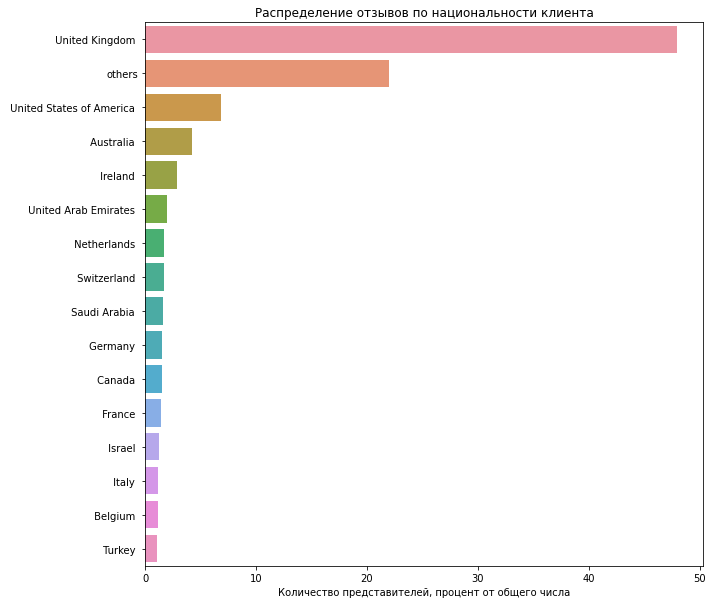

In [ ]:
top_reviewer_nationalities = reviewer_nationality_counts[reviewer_nationality_counts.values>1].index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_reviewer_nationalities else 'others')
reviewer_nationality_counts = data['reviewer_nationality'].value_counts(normalize=True)*100
# визуализация
plt.figure(figsize=(10,10))
barplot = sns.barplot(x=reviewer_nationality_counts.values,
                      y=reviewer_nationality_counts.index,
                      orient='h')
barplot.set_title('Распределение отзывов по национальности клиента')
barplot.set_xlabel('Количество представителей, процент от общего числа');

#### **Признаки 'negative_review','positive_review','review_total_negative_word_count','review_total_positive_word_count'**

In [ ]:
print('Примеры записей отрицательных отзывов\n')
for i in np.random.randint(data.shape[0],size=(5)):
  print('negative_review:',data['negative_review'].iloc[i])
  print('review_total_negative_word_count:',data['review_total_negative_word_counts'].iloc[i])
print('\nПримеры записей положительных отзывов\n')
for i in np.random.randint(data.shape[0],size=(5)):
  print('positive_review:', data['positive_review'].iloc[i])
  print('review_total_positive_word_count:',data['review_total_positive_word_counts'].iloc[i])

Примеры записей отрицательных отзывов

negative_review:  After 10 00 in the evening the only option to go back to the hotel is call a taxi
review_total_negative_word_count: 20
negative_review:  Rooms were tiny 
review_total_negative_word_count: 5
negative_review:  Service is very slow
review_total_negative_word_count: 5
negative_review:  Room service had a late night wanted to order alcohol and food Rang 4 5 times then eventually went down to reception Was told shuts at 1am Very poor
review_total_negative_word_count: 30
negative_review:  I could not get a good nights sleep due to the heat of the room on any of the four nights there as the air conditioning was not available to turn on When I requested at reception that they send up a maintenance man to rectify this I was told it is Autumn They suggested they would send someone up to turn off the unit completely and open the window I told them I had done this and that this did not solve the problem 
review_total_negative_word_count: 87



Заметно, что значения текста отзывов уже были подвержены обработке: отсутствуют знаки препинания, остались только отдельные слова. Также число, которое должно отражать количество слов в отзыве, не соответствует действительному числу слов в том же отзыве. Возможно, это также следствие обработки текста отзыва. Отзывы с текстом "No Positive", "No Negative" имеют нулевые количества слов.

In [ ]:
# функция расчета количества слов в отзыве
def words_counter(text):
  if text=='No Positive' or text=='No Negative':
    return 0
  words_count = len(text.split())
  return words_count

# подсчет слов в отзывах и сравнение с исходными данными
review_total_negative_word_counts_new = data['negative_review'].apply(words_counter)
review_total_positive_word_counts_new = data['positive_review'].apply(words_counter)
neg_words_count_delta = data['review_total_negative_word_counts'] - review_total_negative_word_counts_new
pos_words_count_delta = data['review_total_positive_word_counts'] - review_total_positive_word_counts_new
print('Макс. дельта по количеству слов в отрицательных отзывах:', neg_words_count_delta.max())
print('Макс. дельта по количеству слов в положительных отзывах:', pos_words_count_delta.max())


Макс. дельта по количеству слов в отрицательных отзывах: 2
Макс. дельта по количеству слов в положительных отзывах: 2


Проведенный анализ показывает, что количество слов в отзыве, подсчитанное заново, отличается не более чем на 2 от количества, ранее уже указанного в датасете. Это дает основания доверять данным и пользоваться числами из датасета.

Собственно текст отзыва, учитывая их количество, нуждается в достаточно детальной проработке для последующего анализа и проектирования полезных признаков. В основу анализа признаков плохих и хороших отзывов будет положена оценка количества слов. Обработку текстов отзывов оставим за рамками данного проекта, признаки с текстами отзывов удаляются.

In [ ]:
data = data.drop(['negative_review','positive_review'],axis=1)

Попробуем проанализировать распределения признаков количества слов в негативной и позитивной частях отзывов. Для начала выделим 4 группы отзывов:
- нейтральные - число слов в обоих счетчиках равно 0.
- положительные - число слов в позитивной части ненулевое, в негативной части - нулевое.
- отрицательные - число слов в позитивной части нулевое, в негативной части - ненулевое.
- смешанные - число слов в обоих счетчиках больше 0.

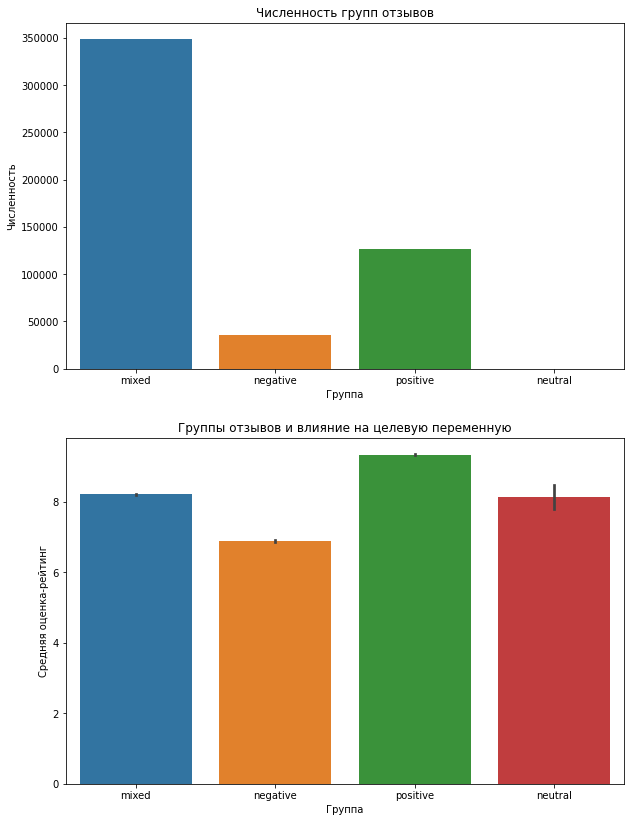

In [ ]:
# функция, выделяющая указанные группы
def get_review_group(df):
  ser = pd.Series('mixed',index=df.index)
  mask = (df['review_total_negative_word_counts']==0)&(df['review_total_positive_word_counts']==0)
  ser.loc[df[mask].index] = 'neutral'
  mask = (df['review_total_negative_word_counts']==0)&(df['review_total_positive_word_counts']>0)
  ser.loc[df[mask].index] = 'positive'
  mask = (df['review_total_negative_word_counts']>0)&(df['review_total_positive_word_counts']==0)
  ser.loc[df[mask].index] = 'negative'
  return ser

data['review_group'] = get_review_group(data)
# визуализация численности выделенных групп
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(10,14))
cp = sns.countplot(data=data,
                   x='review_group',
                   ax=ax[0])
cp.set_title('Численность групп отзывов')
cp.set_xlabel('Группа')
cp.set_ylabel('Численность')
# визуализируем распределение по группам в срезе значений оценок(только размеченые данные)
bp = sns.barplot(data=data[data['sample']==1],
                 y='reviewer_score',
                 x='review_group',
                 ax=ax[1])
bp.set_title('Группы отзывов и влияние на целевую переменную')
bp.set_xlabel('Группа')
bp.set_ylabel('Средняя оценка-рейтинг');


Путем разделения отзывов на 4 вышеперечисленные категории установлено:
- наблюдается ожидаемая зависимость: в группе положительных отзывов наивысшая средняя оценка, в группе отрицательных отзывов - наименьшая.
- в группе нейтральных отзывов наблюдается высокий разброс значений оценки. Учитывая небольшую численность данной категории разумно удалить записи, чтоб "не вводить в заблуждение" модель.
- группа положительных отзывов преобладает над группой отрицательных отзывов в несколько раз по численности.
- преобладающая по численности группа - смешанные отзывы, при этом оценки имеют небольшой разброс, средний бал ожидаемо находится между отметками групп строго положительных и строго отрицательных отзывов.

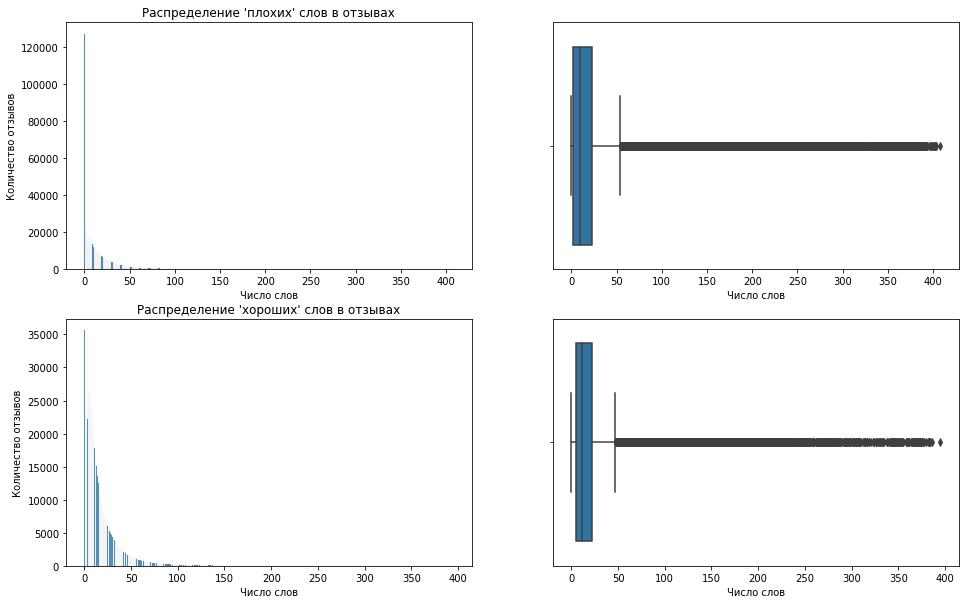

In [ ]:
# Проанализируем распределение численности "хороших" и "плохих" слов в отзывах
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
hp = sns.histplot(x=data['review_total_negative_word_counts'], ax=ax[0,0])
hp.set_title('Распределение \'плохих\' слов в отзывах')
hp.set_xlabel('Число слов')
hp.set_ylabel('Количество отзывов')
bp = sns.boxplot(x=data['review_total_negative_word_counts'], ax=ax[0,1])
bp.set_xlabel('Число слов')
hp = sns.histplot(x=data['review_total_positive_word_counts'], ax=ax[1,0])
hp.set_title('Распределение \'хороших\' слов в отзывах')
hp.set_xlabel('Число слов')
hp.set_ylabel('Количество отзывов')
bp = sns.boxplot(x=data['review_total_positive_word_counts'], ax=ax[1,1])
bp.set_xlabel('Число слов');

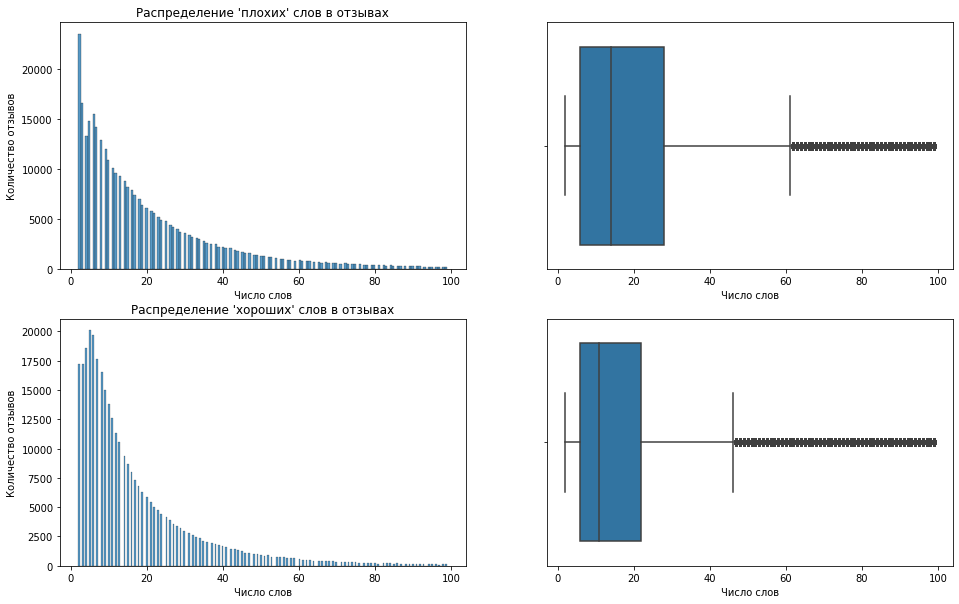

In [ ]:
# Повторим визуализацию для маскированных данных: исключим нулевые длины отзывов и длины отзывов более 100 слов
mask_1 = (data['review_total_negative_word_counts']<100)&(data['review_total_negative_word_counts']>0)
mask_2 = (data['review_total_positive_word_counts']<100)&(data['review_total_positive_word_counts']>0)
mask_3 = mask_1 & mask_2
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(16,10))
hp = sns.histplot(x=data[mask_3]['review_total_negative_word_counts'], ax=ax[0,0])
hp.set_title('Распределение \'плохих\' слов в отзывах')
hp.set_xlabel('Число слов')
hp.set_ylabel('Количество отзывов')
bp = sns.boxplot(x=data[mask_3]['review_total_negative_word_counts'], ax=ax[0,1])
bp.set_xlabel('Число слов')
hp = sns.histplot(x=data[mask_3]['review_total_positive_word_counts'], ax=ax[1,0])
hp.set_title('Распределение \'хороших\' слов в отзывах')
hp.set_xlabel('Число слов')
hp.set_ylabel('Количество отзывов')
bp = sns.boxplot(x=data[mask_3]['review_total_positive_word_counts'], ax=ax[1,1])
bp.set_xlabel('Число слов');

Анализ расперделения отзывов по количеству "плохих" и "хороших" слов демонстрирует ассиметричное распределение, смещенное в сторону коротких отзывов. Распределения схожи между собой. Это свидетельствует о том, что для обработки должны быть применены одинаковые алгоритмы. Также нужно обратить внимание на длину отзывов, количество слов доходит до 400, целесообразно определить критерий по числу слов, превышая который отзыв будет становиться аномально длинным.

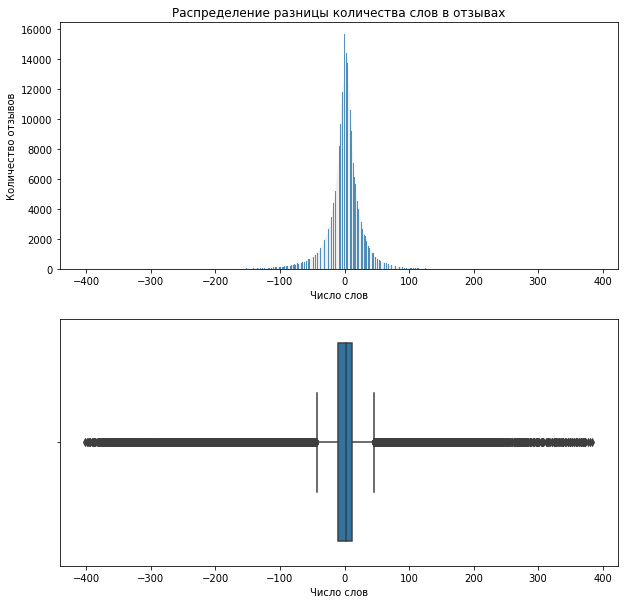

In [ ]:
# Создадим вектор, содержащий разницу между числом хороших и плохих слов и проведем его исследование
detls_words_count = data['review_total_positive_word_counts'] - data['review_total_negative_word_counts']
# визуализация
fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(10,10))
hp = sns.histplot(x=detls_words_count, ax=ax[0])
hp.set_title('Распределение разницы количества слов в отзывах')
hp.set_xlabel('Число слов')
hp.set_ylabel('Количество отзывов')
bp = sns.boxplot(x=detls_words_count, ax=ax[1])
bp.set_xlabel('Число слов');

Графики ожидаемо демонстрируют нормальное распределение с пиком в точке 0. Визуально не снижается количество выбросов, а это значит, что длинные отзывы либо гневные, либо хвалебные. Вектор вводится в датасет в качестве дополнительного признака.

In [ ]:
# создание признака в данных
data['detls_words_count'] = detls_words_count
# Перебор критической длины отзыва и оценка размера маскированной выборки
crit_len_lst = np.arange(100,300,50)
for crit_len in crit_len_lst:
  del_shape = np.extract(detls_words_count>crit_len,detls_words_count).shape[0] + np.extract(detls_words_count<-crit_len,detls_words_count).shape[0]
  del_shape_percent = del_shape/detls_words_count.shape[0]*100
  print('При критической длине {} слов теряется {} записей ({:.2f} % всех данных)'.format(crit_len,del_shape,del_shape_percent))


При критической длине 100 слов теряется 10861 записей (2.13 % всех данных)
При критической длине 150 слов теряется 4082 записей (0.80 % всех данных)
При критической длине 200 слов теряется 1815 записей (0.36 % всех данных)
При критической длине 250 слов теряется 943 записей (0.18 % всех данных)


Выбирается критерий длины отзыва 150 слов. Записи, не выдерживающие критерий, удаляются.

In [ ]:
# убираем записи из обучающей выборки
mask = ((data['detls_words_count']>150)|(data['detls_words_count']<-150))&(data['sample']==1)
data = data.drop(index=data[mask].index,axis=0)
data.shape

(508007, 22)

#### **Признаки 'average_score', 'additional_number_of_scoring', 'total_number_of_reviews'**

In [ ]:
# обзор статистических показателей параметров
data[['total_number_of_reviews','average_score','additional_number_of_scoring']].describe()

,total_number_of_reviews,average_score,additional_number_of_scoring
count,508007.000000,508007.000000,508007.000000
mean,2744.324397,8.398800,498.157955
std,2317.327701,0.547628,500.585542
min,43.000000,5.200000,1.000000
25%,1161.000000,8.100000,169.000000
50%,2134.000000,8.400000,342.000000
75%,3613.000000,8.800000,660.000000
max,16670.000000,9.800000,2682.000000


In [ ]:
# группируем данные по названию отеля и считаем количество уникальных значений параметров
data.groupby(by=['city','hotel_name'])[['total_number_of_reviews','average_score','additional_number_of_scoring']].nunique().value_counts()

total_number_of_reviews  average_score  additional_number_of_scoring
1                        1              1                               1494
dtype: int64

Анализ признаков показал, что во всем объеме данных их значения неизменны для каждого из отелей, т.е. данные признаки можно считать параметрами отелей, а не отзывов.

In [ ]:
# формируем таблицу отелей с рассматриваемыми признаками,кроме 'average_score'
hotels_temp = data.groupby(by=['city','hotel_name'])[['total_number_of_reviews','average_score','additional_number_of_scoring']].median()
# объединяем с ранее созданной таблицей hotels
hotels = hotels.merge(hotels_temp,on=['city','hotel_name'])
hotels.head(3)

,city,hotel_name,distance,total_number_of_reviews,average_score,additional_number_of_scoring
0,Amsterdam,Albus Hotel Amsterdam City Centre,0.008916,564.0,8.2,95.0
1,Amsterdam,Amadi Panorama Hotel,0.100063,2586.0,8.4,253.0
2,Amsterdam,Amadi Park Hotel,0.018546,1615.0,8.1,272.0


В таблицу hotels можно добавить значения, расчитанные по датасету, в частности количество отзывов для каждого отеля и средние оценки отелей.

In [ ]:
# рассчитаем средние оценки каждого отеля и также добавим их в hotels
mask=data['sample']==1  # рассматриваем только обучающую выборку, т.к. оценки в тестовой выборке неизвестны и обнулены
hotels_av_sc_from_data = data[mask].groupby(by=['city','hotel_name'])['reviewer_score'].mean()
hotels = hotels.merge(hotels_av_sc_from_data,on=['city','hotel_name']).rename(columns={'reviewer_score':'average_score_new'})
# добавим в hotels количество отзывов, которое расчитано по датасету
hotels_number_reviews_from_data = data.groupby(by=['city','hotel_name'])['reviewer_score'].count()
hotels = hotels.merge(hotels_number_reviews_from_data,on=['city','hotel_name']).rename(columns={'reviewer_score':'total_number_of_reviews_new'})
hotels.head(3)

,city,hotel_name,distance,total_number_of_reviews,average_score,additional_number_of_scoring,average_score_new,total_number_of_reviews_new
0,Amsterdam,Albus Hotel Amsterdam City Centre,0.008916,564.0,8.2,95.0,8.198630,191
1,Amsterdam,Amadi Panorama Hotel,0.100063,2586.0,8.4,253.0,8.449133,474
2,Amsterdam,Amadi Park Hotel,0.018546,1615.0,8.1,272.0,8.220727,392


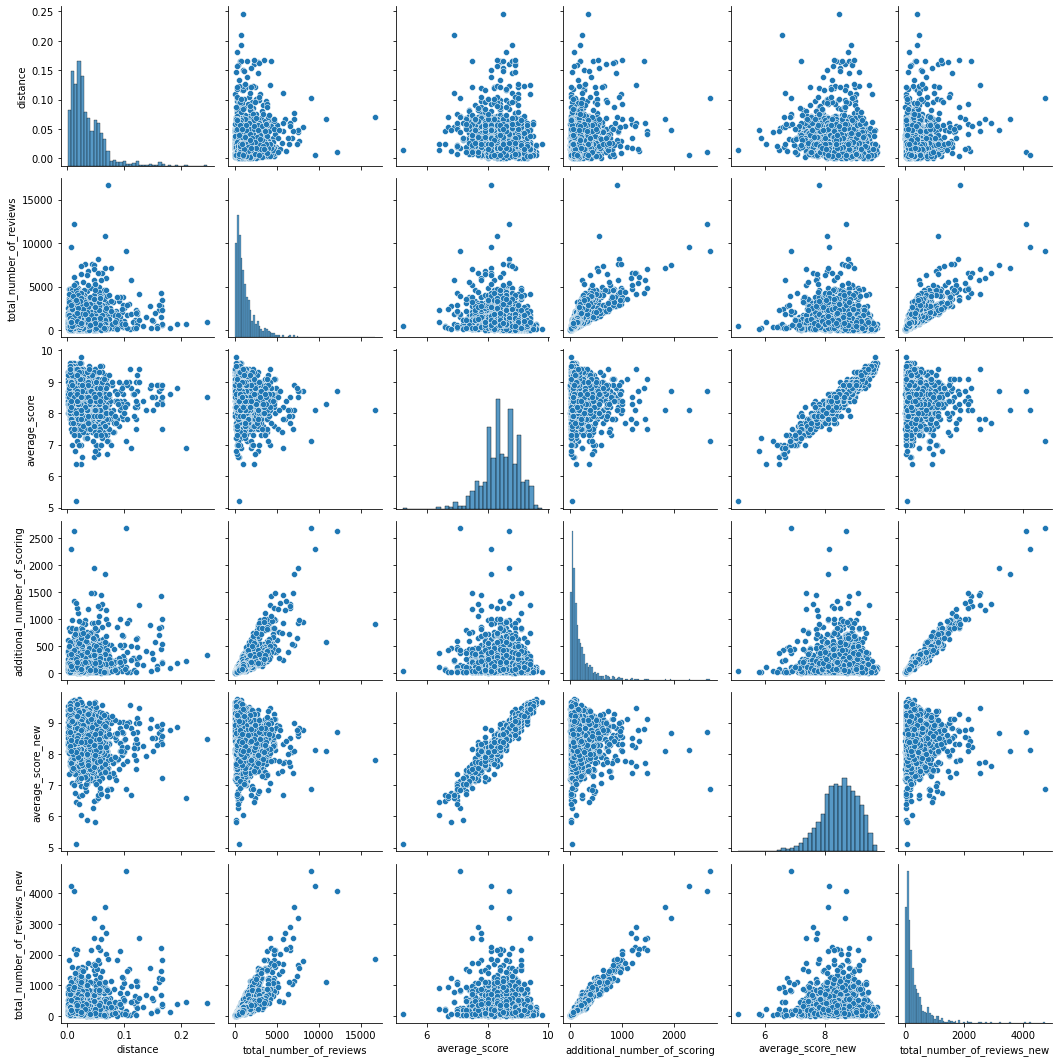

In [ ]:
# визуализируем попарное распределение значений признаков
sns.pairplot(hotels);

1. В распределении многих признаков наблюдается большое число выбросов - аномальных значений параметров, выделяющихся из всей массы. При этом каждая точка на графике обозначает собой целый отель, т.е. удаление выбросов грозит исключением отзывов всего отеля из датасета data. Удаление таких отелей не производится.
2. Наблюдается связь некоторых признаков, в некоторых случаях достаточно сильная. Например, средние оценки отеля, подсчитанные по базе данных находятся вблизи средней оценки, ранее уже записанной в датасет. Разумно ввести признак-коэффициент, содержащий отношение новой оценки к старой. Назовем его индексом рейтинга: при значении выше 1 отель набирает рейтинг, ниже 1 - теряет.Также в таблицу отелей вводится параметр, отражающий долю "честных" отзывов, под "честными" понимаются именно отзывы, а не просто оценки.

In [ ]:
# доля настоящих отзывов
hotels['clean_reviews'] = 1 - hotels['additional_number_of_scoring']/hotels['total_number_of_reviews']
# индекс рейтинга
hotels['rating_index'] = hotels['average_score_new']/hotels['average_score']

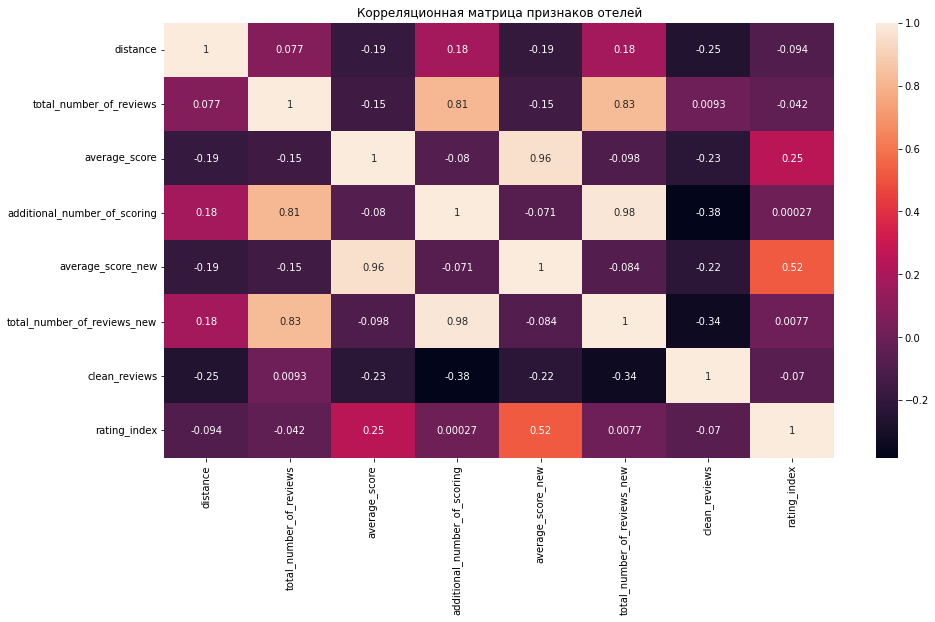

In [ ]:
# корреляционная матрица признаков таблицы hotels
hotels_corr = hotels.corr()
fig = plt.figure(figsize=(15,8))
hotels_hm = sns.heatmap(hotels_corr,annot=True)
hotels_hm.set_title('Корреляционная матрица признаков отелей');

В корреляционной матрице наблюдаются высокие коэффициенты корреляции между признаками. Необходимо избавиться от неинформативных признаков и их мультиколлинеарности.

In [ ]:
# корреляционные коэффициенты целевой переменной
hotels_corr.average_score_new

distance                       -0.192957
total_number_of_reviews        -0.149167
average_score                   0.957715
additional_number_of_scoring   -0.071053
average_score_new               1.000000
total_number_of_reviews_new    -0.084483
clean_reviews                  -0.224124
rating_index                    0.519149
Name: average_score_new, dtype: float64

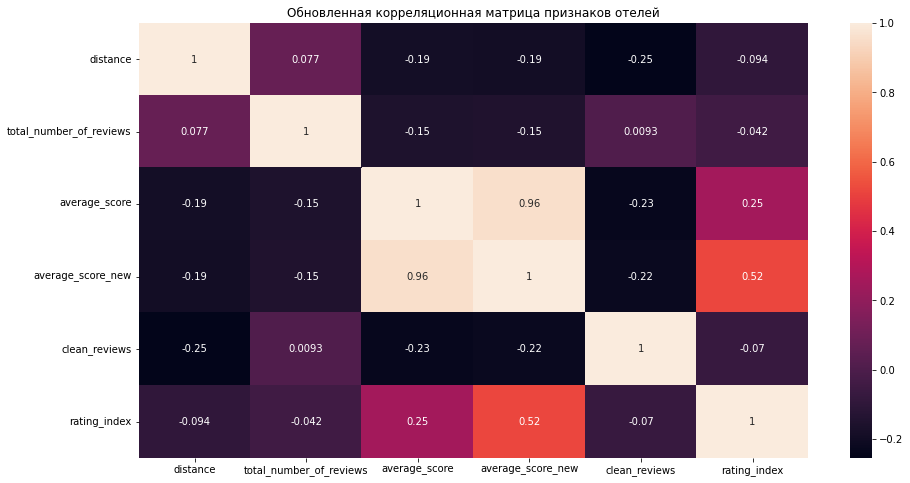

In [ ]:
# оставим признаки, корреляция которых с целевой переменной более +-0.1
drop_cols = list(hotels_corr[(hotels_corr['average_score_new']>-0.1)&(hotels_corr['average_score_new']<0.1)]['average_score_new'].index)
hotels = hotels.drop(drop_cols,axis=1)
# обновляем корреляционную матрицу и визуализируем в виде тепловой карты
hotels_corr = hotels.corr()
fig = plt.figure(figsize=(15,8))
hotels_hm = sns.heatmap(hotels_corr,annot=True)
hotels_hm.set_title('Обновленная корреляционная матрица признаков отелей');


После удаления неинформативных признаков в корреляционной матрице нет сильно связанных друг с другом признаков, при этом достигнуты сравнительно высокие значения некоторых из коэффициентов корреляции с целевой переменной. Признаки distance, total_number_of_reviews, average_score ранее были взяты из таблицы data. Таким образом остается 2 признака, которые нужно добавить в data

In [ ]:
# оставляем в hotels признаки clean_reviews и rating_index, встраиваем новые предикторы из hotels в data
hotels = hotels[['city','hotel_name','clean_reviews','rating_index']]
data = data.merge(hotels,on=['city','hotel_name'],how='left')

#### **Признак 'total_number_of_reviews_reviewer_has_given'**

In [ ]:
# обзор статистических показателей параметра
data['total_number_of_reviews_reviewer_has_given'].describe()

count    508007.000000
mean          7.172102
std          11.061067
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         355.000000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

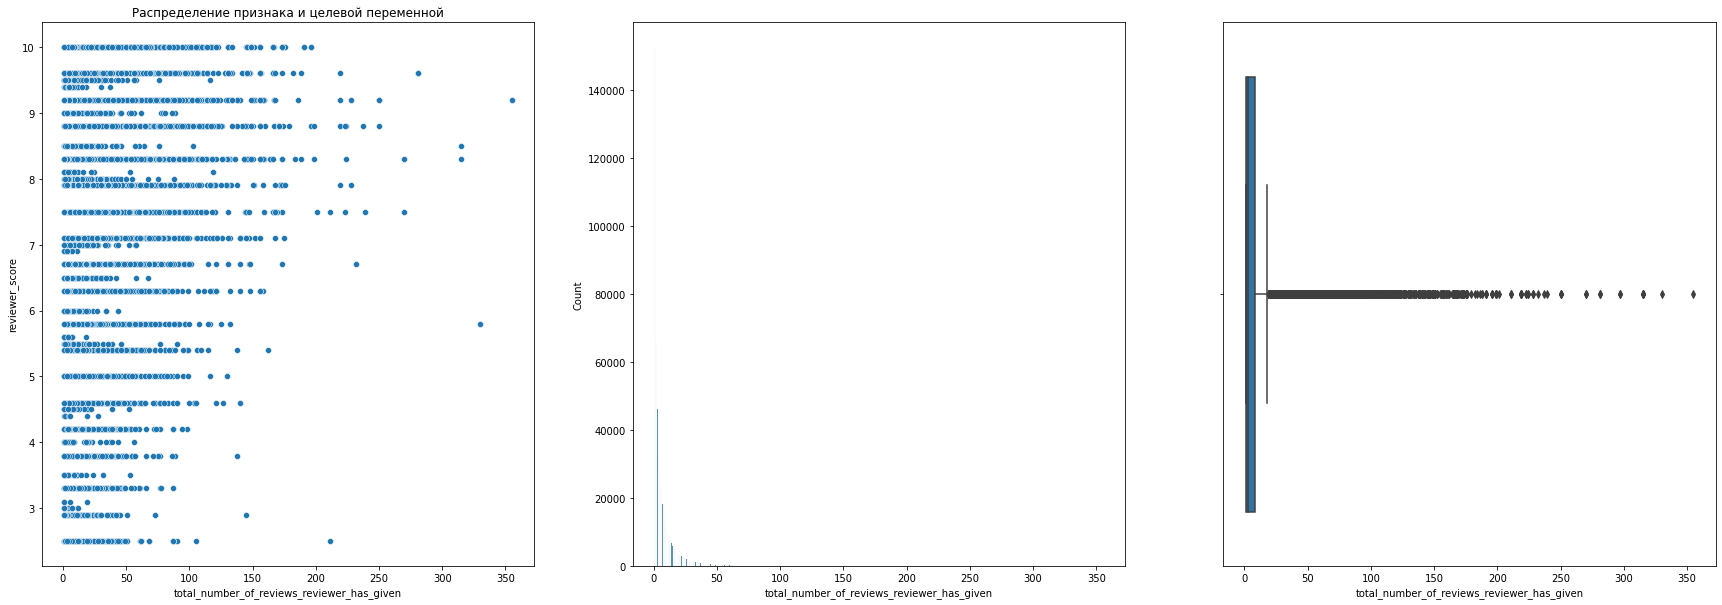

In [ ]:
# визуализация
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(30,10))
# влияние целевую переменную
sp = sns.scatterplot(data=data[data['sample']==1],
                     x='total_number_of_reviews_reviewer_has_given',
                     y='reviewer_score',
                     ax=ax[0])
sp.set_title('Распределение признака и целевой переменной')
hp = sns.histplot(x=data['total_number_of_reviews_reviewer_has_given'],ax=ax[1])
bp = sns.boxplot(x=data['total_number_of_reviews_reviewer_has_given'],ax=ax[2]);

Очевидной связи параметра и целевой переменной не наблюдается, распределение подобно экспоненциальному с максимумом на отметке 1. Начиная с отметки в 25 отзывов значения считаются выбросами. Проанализируем объем данных со значениями признака более 50.

In [ ]:
# выделим признак в отдельный массив
reviews_from_reviewer = data['total_number_of_reviews_reviewer_has_given'].values
# Перебор критического количества отзывов и оценка размера маскированной выборки
crit_qnt_lst = np.arange(50,301,50)
for crit_qnt in crit_qnt_lst:
  del_shape = np.extract(reviews_from_reviewer>crit_qnt,reviews_from_reviewer).shape[0]
  del_shape_percent = del_shape/reviews_from_reviewer.shape[0]*100
  print('При критическом количестве отзывов {} теряется {} записей ({:.2f} % всех данных)'.format(crit_qnt,del_shape,del_shape_percent))

При критическом количестве отзывов 50 теряется 5623 записей (1.11 % всех данных)
При критическом количестве отзывов 100 теряется 606 записей (0.12 % всех данных)
При критическом количестве отзывов 150 теряется 171 записей (0.03 % всех данных)
При критическом количестве отзывов 200 теряется 32 записей (0.01 % всех данных)
При критическом количестве отзывов 250 теряется 12 записей (0.00 % всех данных)
При критическом количестве отзывов 300 теряется 6 записей (0.00 % всех данных)


In [ ]:
# учитывая низкий процент записей с аномальным значением признака удаляются записи с числом отзывов более 50
mask = (data['total_number_of_reviews_reviewer_has_given']>50)&(data['sample']==1)
data = data.drop(index=data[mask].index,axis=0)
data.shape

(503785, 24)

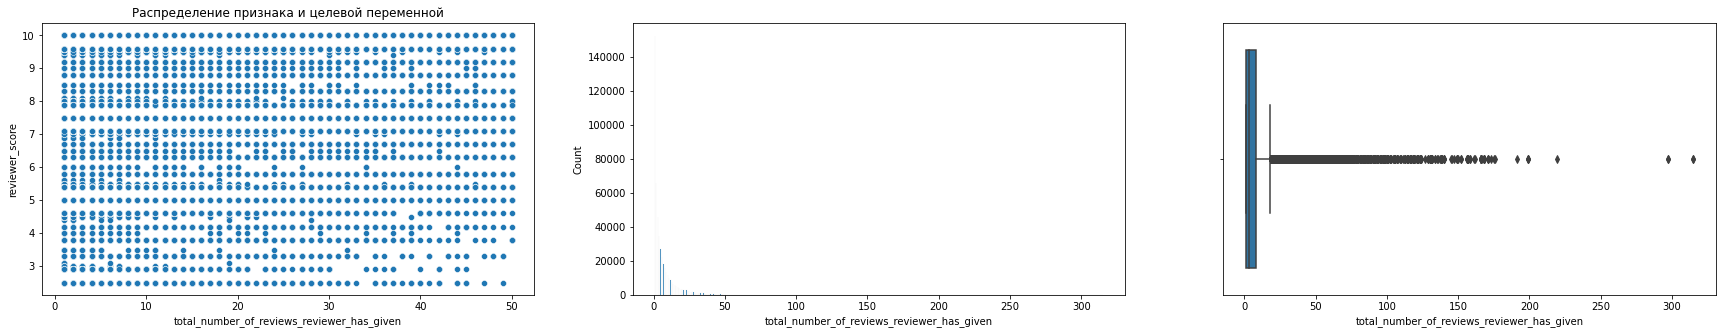

In [ ]:
# визуализация после удаления аномальных записей
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(30,5))
# влияние целевую переменную
sp = sns.scatterplot(data=data[data['sample']==1],
                     x='total_number_of_reviews_reviewer_has_given',
                     y='reviewer_score',
                     ax=ax[0])
sp.set_title('Распределение признака и целевой переменной')
hp = sns.histplot(x=data['total_number_of_reviews_reviewer_has_given'],ax=ax[1])
bp = sns.boxplot(x=data['total_number_of_reviews_reviewer_has_given'],ax=ax[2]);

#### **Кодирование признаков**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503785 entries, 0 to 508006
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                503785 non-null  int64         
 1   review_date                                 503785 non-null  datetime64[ns]
 2   average_score                               503785 non-null  float64       
 3   hotel_name                                  503785 non-null  object        
 4   reviewer_nationality                        503785 non-null  object        
 5   review_total_negative_word_counts           503785 non-null  int64         
 6   total_number_of_reviews                     503785 non-null  int64         
 7   review_total_positive_word_counts           503785 non-null  int64         
 8   total_number_of_reviews_reviewer_has_given  503785 non-null  int64        

На данном этапе в данных введены новые признаки, разработанные в ходе анализа данных, и удалены записи тренировочной выборки, содержащие аномальные значения признаков. Далее обработка данных будет построена по следующему сценарию:
1. Удаление некоторых исходных признаков, нецелесообразных для использования в модели
2. Кодирование категориальных признаков

In [ ]:
# удаление признаков
drop_cols = ['review_date',
             'hotel_name',
             'tags']
data = data.drop(drop_cols,axis=1)

In [ ]:
# перевод числовых признаков в категориальные
data[['month_review','year_review']] = data[['month_review','year_review']].astype(str)

In [ ]:
# однократное кодирование категориальных признаков
data = pd.get_dummies(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503785 entries, 0 to 508006
Data columns (total 62 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     503785 non-null  int64  
 1   average_score                                    503785 non-null  float64
 2   review_total_negative_word_counts                503785 non-null  int64  
 3   total_number_of_reviews                          503785 non-null  int64  
 4   review_total_positive_word_counts                503785 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given       503785 non-null  int64  
 6   sample                                           503785 non-null  int64  
 7   reviewer_score                                   503785 non-null  float64
 8   distance                                         503785 non-null  float64
 9   count_nights   

#### **Анализ значимости и отбор признаков**

In [ ]:
data_corr = data[data['sample']==1].corr()
# коэффициенты корреляции с целевой переменной
reviewer_score_coefs = data_corr['reviewer_score'].apply(abs).sort_values(ascending=False)
reviewer_score_coefs[:20]

reviewer_score                                     1.000000
detls_words_count                                  0.485675
review_total_negative_word_counts                  0.385498
average_score                                      0.363354
review_group_positive                              0.329882
review_group_negative                              0.253021
review_total_positive_word_counts                  0.235706
rating_index                                       0.187652
review_group_mixed                                 0.168547
trip_target_Leisure trip                           0.118214
trip_target_Business trip                          0.118214
type_guests_Solo traveler                          0.085750
total_number_of_reviews                            0.073113
type_guests_Couple                                 0.069535
reviewer_nationality_ United States of America     0.064204
distance                                           0.062926
reviewer_nationality_others             

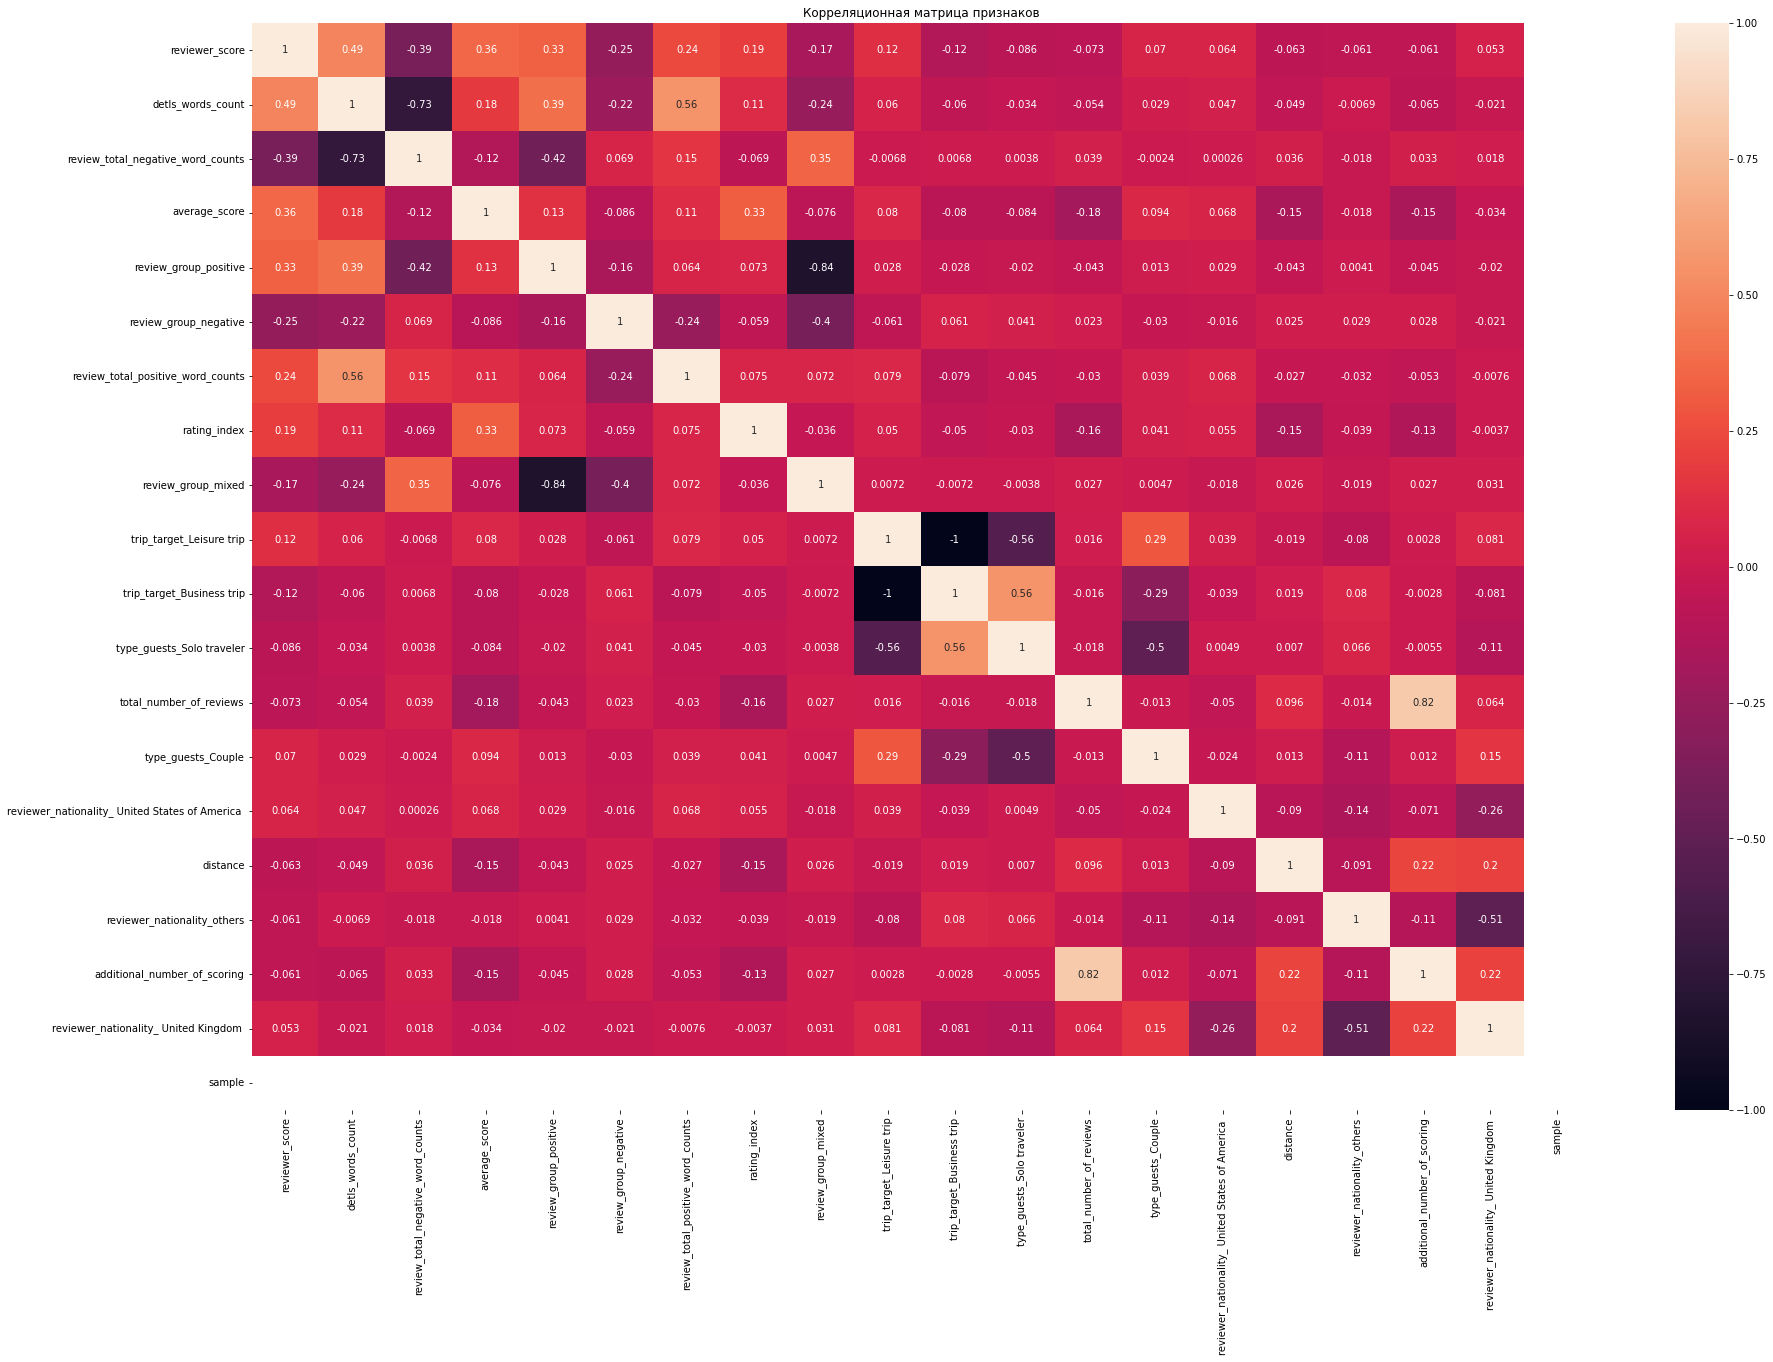

In [ ]:
# выделим признаки, коэффициент корреляции которых более 0,05 по модулю
reviewer_score_coefs = reviewer_score_coefs[reviewer_score_coefs>0.05]
cols = list(reviewer_score_coefs.index)
cols.append('sample')
data = data[cols]
data_corr = data[data['sample']==1].corr()
# построение корреляционной матрицы
fig = plt.figure(figsize=(30,20))
data_hm = sns.heatmap(data_corr,annot=True)
data_hm.set_title('Корреляционная матрица признаков');

Построенная тепловая карта иллюстрирует места мультиколлинеарности признаков. Учитывая, что некоторые признаки являются линейной комбинацией других, это ожидаемо. Необходимо выделить признаки, наиболее коррелированных с целевой переменной, и в случае их коллинеарности с другими признаками, удалить последние.

In [ ]:
# убираем признаки мультиколлинеарные признаки
drop_cols = ['review_total_negative_word_counts',
             'review_group_mixed',
             'trip_target_Business trip',
             'additional_number_of_scoring']
data = data.drop(columns=drop_cols)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503785 entries, 0 to 508006
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   reviewer_score                                   503785 non-null  float64
 1   detls_words_count                                503785 non-null  int64  
 2   average_score                                    503785 non-null  float64
 3   review_group_positive                            503785 non-null  uint8  
 4   review_group_negative                            503785 non-null  uint8  
 5   review_total_positive_word_counts                503785 non-null  int64  
 6   rating_index                                     503785 non-null  float64
 7   trip_target_Leisure trip                         503785 non-null  uint8  
 8   type_guests_Solo traveler                        503785 non-null  uint8  
 9   total_number_of

### **Моделирование**

In [ ]:
# Теперь выделим тестовую и обучающую части
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)
X_test = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 15), (374850, 15), (374850, 14), (299880, 14), (128935, 14))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_valid)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.9s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_valid, y_pred))

MAE: 0.9617828303171779


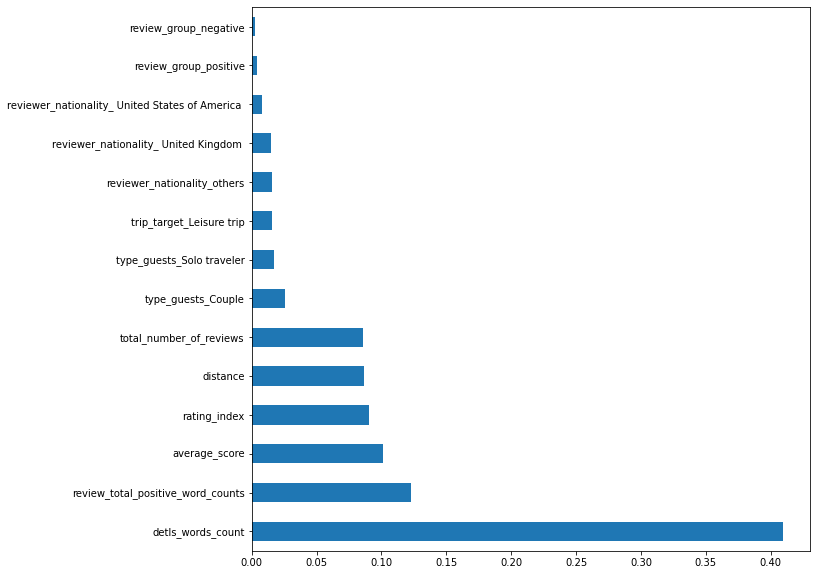

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

,reviewer_score,detls_words_count,average_score,review_group_positive,review_group_negative,review_total_positive_word_counts,rating_index,trip_target_Leisure trip,type_guests_Solo traveler,total_number_of_reviews,type_guests_Couple,reviewer_nationality_ United States of America,distance,reviewer_nationality_others,reviewer_nationality_ United Kingdom
36078,0.0,3,8.8,0,0,26,1.006609,1,0,1803,1,0,0.021074,1,0
91953,0.0,-10,8.8,0,0,6,1.006294,1,0,1420,0,0,0.022362,0,1
52580,0.0,2,8.2,0,0,8,1.012849,0,1,2968,0,0,0.025929,0,1
62335,0.0,23,9.4,0,0,25,0.996220,1,0,2200,1,0,0.040383,0,1
11801,0.0,7,7.9,1,0,7,0.978731,1,0,983,1,0,0.052807,0,1
76621,0.0,-19,8.8,0,1,0,1.002362,1,0,2213,0,0,0.062745,0,1
62715,0.0,5,9.2,0,0,17,1.018691,0,0,803,1,1,0.009300,0,0
111714,0.0,-23,8.1,0,0,11,0.999278,1,0,3826,1,0,0.092390,0,1
48872,0.0,12,9.3,1,0,12,0.979277,1,0,320,1,0,0.019179,0,1
96140,0.0,-11,7.5,0,0,9,0.991844,1,0,2746,1,0,0.035299,0,0


In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [ ]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.6s finished


In [ ]:
predict_submission

array([8.536 , 7.5235, 7.903 , ..., 8.034 , 9.389 , 7.8842])

In [ ]:
list(sample_submission)

['reviewer_score', 'id']

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.53600,488440
1,7.52350,274649
2,7.90300,374688
3,9.84300,404352
4,9.79685,451596
5,8.84800,302161
6,5.57700,317079
7,7.90500,13963
8,8.67700,159785
9,8.16800,195089
